In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import re
plt.style.use('ggplot')
pd.set_option('display.max_rows', 200, 'display.max_columns', 200)
pd.options.display.float_format = '{:,.2f}'.format


In [2]:
raw_df = pd.read_csv("data/loan.csv")

/Users/innoppl/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1. Remove current status loans
2. Drop unnecessary columns not related to the loans
3. Fix Rows and columns. ensure standardized naming.
4. Identify a single unique identifier
5. Identify missing values. 
5a. Ignore columns with majoirty missing value
5b. use missing value replacement techniques
6. Fix invalid values
7. Outlier Treatment
8. Standardize values


In [3]:
raw_df.shape

(39717, 111)

## 1. Check for fixing rows and columns

In [4]:
raw_df.head(5) ## Check for header and footer rows

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,"4,975.00",36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,"24,000.00",Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,"5,863.16","5,833.84","5,000.00",863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,"2,500.00",60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,"30,000.00",Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,"1,008.71","1,008.71",456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,"2,400.00",36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,"12,252.00",Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,"3,005.67","3,005.67","2,400.00",605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,"10,000.00",36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,"49,200.00",Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.00,NaN,10,0,5598,21%,37,f,0.00,0.00,"12,231.89","12,231.89","10,000.00","2,214.92",16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [5]:
## check for empty/weird column names
for col in raw_df.columns:
    print(col)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc

In [6]:
## Keep one id column out of member id, id
## Drop columns with less variation in its values
## Tackle null values

In [7]:
null_percentage = (raw_df.isnull().sum() / raw_df.shape[0] * 100.00).reset_index()
null_percentage.columns = ['column_name','null_percent']
null_percentage = null_percentage.sort_values('null_percent', ascending=False)
null_percentage

,column_name,null_percent
55,verification_status_joint,100.00
53,annual_inc_joint,100.00
81,mo_sin_old_rev_tl_op,100.00
80,mo_sin_old_il_acct,100.00
77,bc_util,100.00
76,bc_open_to_buy,100.00
75,avg_cur_bal,100.00
74,acc_open_past_24mths,100.00
73,inq_last_12m,100.00
72,total_cu_tl,100.00


In [8]:
columns_to_remove = null_percentage[null_percentage.null_percent>=100].column_name.to_list()

In [9]:
## Member id vs loan id

In [10]:
raw_df.id.nunique(), raw_df.member_id.nunique() # there is unique per row, we can drop either of them

(39717, 39717)

In [11]:
columns_to_remove.append('member_id')

In [12]:
columns_to_remove

['verification_status_joint',
 'annual_inc_joint',
 'mo_sin_old_rev_tl_op',
 'mo_sin_old_il_acct',
 'bc_util',
 'bc_open_to_buy',
 'avg_cur_bal',
 'acc_open_past_24mths',
 'inq_last_12m',
 'total_cu_tl',
 'inq_fi',
 'total_rev_hi_lim',
 'all_util',
 'max_bal_bc',
 'open_rv_24m',
 'open_rv_12m',
 'il_util',
 'total_bal_il',
 'mths_since_rcnt_il',
 'open_il_24m',
 'open_il_12m',
 'open_il_6m',
 'open_acc_6m',
 'tot_cur_bal',
 'tot_coll_amt',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'num_rev_tl_bal_gt_0',
 'total_bc_limit',
 'total_bal_ex_mort',
 'tot_hi_cred_lim',
 'percent_bc_gt_75',
 'pct_tl_nvr_dlq',
 'num_tl_op_past_12m',
 'num_tl_90g_dpd_24m',
 'num_tl_30dpd',
 'num_tl_120dpd_2m',
 'num_sats',
 'num_rev_accts',
 'mths_since_recent_bc',
 'num_op_rev_tl',
 'num_il_tl',
 'num_bc_tl',
 'num_bc_sats',
 'num_actv_rev_tl',
 'num_actv_bc_tl',
 'num_accts_ever_120_pd',
 'mths_since_recent_revol_delinq',
 'mths_since_recent_inq',
 'mths_since_recent_bc_dlq',
 'dti_joint',
 '

In [13]:
columns_to_keep = [x for x in raw_df.columns if x not in columns_to_remove]

In [14]:
len(raw_df.columns), len(columns_to_keep),len(columns_to_remove)

(111, 56, 55)

In [15]:
non_null_df = raw_df[columns_to_keep]

In [16]:
non_null_df.shape

(39717, 56)

In [17]:
non_null_df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype

In [18]:
# Identify textual columns to split in the above list and split - 

In [19]:
# Identify % of missing values in each column and suggest appropriate solution
percent_missing = non_null_df.isnull().sum() * 100 / len(non_null_df)

In [20]:
print(percent_missing)

id                            0.00
loan_amnt                     0.00
funded_amnt                   0.00
funded_amnt_inv               0.00
term                          0.00
int_rate                      0.00
installment                   0.00
grade                         0.00
sub_grade                     0.00
emp_title                     6.19
emp_length                    2.71
home_ownership                0.00
annual_inc                    0.00
verification_status           0.00
issue_d                       0.00
loan_status                   0.00
pymnt_plan                    0.00
url                           0.00
desc                         32.58
purpose                       0.00
title                         0.03
zip_code                      0.00
addr_state                    0.00
dti                           0.00
delinq_2yrs                   0.00
earliest_cr_line              0.00
inq_last_6mths                0.00
mths_since_last_delinq       64.66
mths_since_last_reco

In [21]:
## Check column variations
columns_to_remove2 = non_null_df.columns[non_null_df.nunique(dropna=True) <= 1].to_list()
# add textual columns of no use
columns_to_remove2.append('desc')
columns_to_remove2.append('url')


In [22]:
non_null_df2= non_null_df[[x for x in non_null_df.columns if x not in columns_to_remove2]]

In [23]:
non_null_df2.dtypes.sort_values()

id                           int64
open_acc                     int64
pub_rec                      int64
revol_bal                    int64
total_acc                    int64
inq_last_6mths               int64
delinq_2yrs                  int64
funded_amnt                  int64
loan_amnt                    int64
total_rec_int              float64
total_rec_prncp            float64
total_pymnt_inv            float64
recoveries                 float64
out_prncp_inv              float64
out_prncp                  float64
collection_recovery_fee    float64
last_pymnt_amnt            float64
mths_since_last_record     float64
mths_since_last_delinq     float64
total_rec_late_fee         float64
total_pymnt                float64
pub_rec_bankruptcies       float64
funded_amnt_inv            float64
installment                float64
annual_inc                 float64
dti                        float64
last_credit_pull_d          object
next_pymnt_d                object
last_pymnt_d        

In [24]:
# Converting string percentage of 'revol_util' to float value without percentage symbol
non_null_df2['revol_util'] = non_null_df2['revol_util'].str.rstrip('%').astype('float') / 100.0


/var/folders/qg/f8f8j4192yd6xfhtrhlvy3gw0000gn/T/ipykernel_2516/4262549611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_df2['revol_util'] = non_null_df2['revol_util'].str.rstrip('%').astype('float') / 100.0


In [25]:
# Converting string percentage of 'int_rate' to float value without percentage symbol

non_null_df2['int_rate'] = non_null_df2['int_rate'].str.rstrip('%').astype('float') / 100.0


/var/folders/qg/f8f8j4192yd6xfhtrhlvy3gw0000gn/T/ipykernel_2516/2656024909.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_df2['int_rate'] = non_null_df2['int_rate'].str.rstrip('%').astype('float') / 100.0


In [26]:
#converting 'term' string to 'term' int by removing ' months'
non_null_df2['term'] = non_null_df2['term'].str.replace(' months', '', regex=True).astype(int)

/var/folders/qg/f8f8j4192yd6xfhtrhlvy3gw0000gn/T/ipykernel_2516/1333448380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_df2['term'] = non_null_df2['term'].str.replace(' months', '', regex=True).astype(int)


In [27]:
# converting 'emp_length' string into float by removing 'year','years' and consider '10+' to '10'. Also '< 1' to '0.5'
non_null_df2['emp_length'] = non_null_df2['emp_length'].str.replace('years','').str.replace('year','').str.replace('10\+ ','10',regex=True).str.replace('< 1 ', '0.5')

/var/folders/qg/f8f8j4192yd6xfhtrhlvy3gw0000gn/T/ipykernel_2516/1757306046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_df2['emp_length'] = non_null_df2['emp_length'].str.replace('years','').str.replace('year','').str.replace('10\+ ','10',regex=True).str.replace('< 1 ', '0.5')


In [28]:
non_null_df2['emp_length'] = non_null_df2['emp_length'].astype(float)

/var/folders/qg/f8f8j4192yd6xfhtrhlvy3gw0000gn/T/ipykernel_2516/2179987641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_df2['emp_length'] = non_null_df2['emp_length'].astype(float)


In [29]:
non_null_df2.dtypes.sort_values()

id                           int64
open_acc                     int64
pub_rec                      int64
revol_bal                    int64
total_acc                    int64
delinq_2yrs                  int64
inq_last_6mths               int64
term                         int64
funded_amnt                  int64
loan_amnt                    int64
total_rec_late_fee         float64
total_rec_int              float64
total_rec_prncp            float64
total_pymnt_inv            float64
collection_recovery_fee    float64
out_prncp_inv              float64
out_prncp                  float64
revol_util                 float64
last_pymnt_amnt            float64
mths_since_last_record     float64
mths_since_last_delinq     float64
recoveries                 float64
total_pymnt                float64
pub_rec_bankruptcies       float64
dti                        float64
funded_amnt_inv            float64
int_rate                   float64
installment                float64
annual_inc          

In [30]:
# Just check all index are float 
non_null_df2.emp_length.value_counts().index

Float64Index([10.0, 0.5, 2.0, 3.0, 4.0, 5.0, 1.0, 6.0, 7.0, 8.0, 9.0], dtype='float64')

In [31]:
# Univariate - Categorical - Unorder - Using rank plot - Log log scale - Power distribution 

In [32]:
# Here applying rank for 'annual_inc'
non_null_df2["Rank"] = non_null_df2["purpose"].rank()

/var/folders/qg/f8f8j4192yd6xfhtrhlvy3gw0000gn/T/ipykernel_2516/2650990856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_df2["Rank"] = non_null_df2["purpose"].rank()


In [33]:
# Include frequency 

In [34]:
# Log scale applied for x axis
#non_null_df2.plot(x="Rank", y=["purpose"], logx=True)

In [35]:
# Univariate - Categorical - Order -  histogram / Bar plot 

<AxesSubplot:>

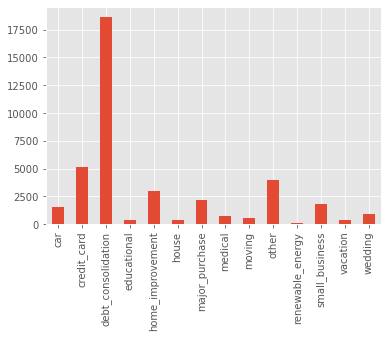

In [36]:
non_null_df2['purpose'].value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

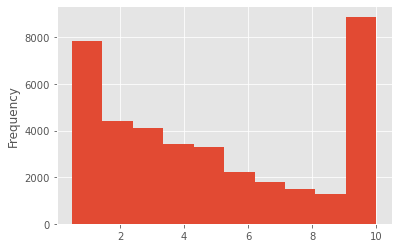

In [37]:
non_null_df2['emp_length'].plot.hist()

In [38]:
# Univaraite - Numeric - Box Plot 

In [39]:
non_null_df2['loan_amnt'].describe()


count   39,717.00
mean    11,219.44
std      7,456.67
min        500.00
25%      5,500.00
50%     10,000.00
75%     15,000.00
max     35,000.00
Name: loan_amnt, dtype: float64

<AxesSubplot:>

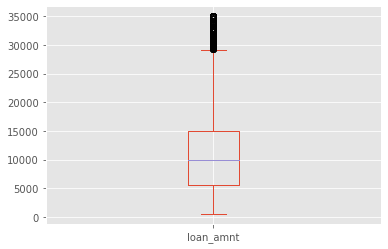

In [40]:
non_null_df2['loan_amnt'].plot.box()

In [41]:
non_null_df2['total_pymnt_inv'].describe()

count   39,717.00
mean    11,567.15
std      8,942.67
min          0.00
25%      5,112.31
50%      9,287.15
75%     15,798.81
max     58,563.68
Name: total_pymnt_inv, dtype: float64

<AxesSubplot:>

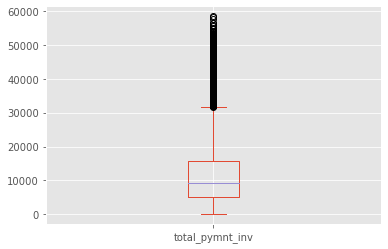

In [42]:
non_null_df2['total_pymnt_inv'].plot.box()

In [43]:
non_null_df2["annual_inc"].describe()

count      39,717.00
mean       68,968.93
std        63,793.77
min         4,000.00
25%        40,404.00
50%        59,000.00
75%        82,300.00
max     6,000,000.00
Name: annual_inc, dtype: float64

<AxesSubplot:>

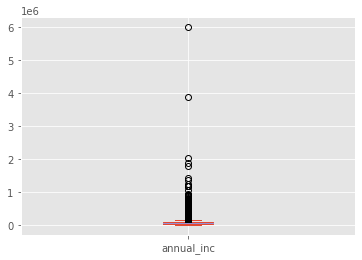

In [44]:
non_null_df2['annual_inc'].plot.box()

In [45]:
non_null_df2["annual_inc"].quantile(0.10)

30000.0

In [46]:
non_null_df2["annual_inc"].quantile(0.99)

234999.36

In [47]:
# Remove Outliers > 0.10 quantile and < .99 from Annual Income

non_null_df2 = non_null_df2[(non_null_df2["annual_inc"] > non_null_df2["annual_inc"].quantile(0.10)) & (non_null_df2["annual_inc"] < non_null_df2["annual_inc"].quantile(0.99))]

# After Removal of Outliers 
print(non_null_df2["annual_inc"].describe())


count    34,695.00
mean     71,104.43
std      33,711.79
min      30,004.00
25%      47,000.00
50%      62,000.00
75%      85,000.00
max     234,996.00
Name: annual_inc, dtype: float64


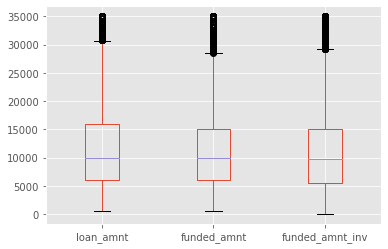

In [48]:
# Mulit varibale box plotting 
boxplot = non_null_df2.boxplot(column=['loan_amnt', 'funded_amnt', 'funded_amnt_inv'])

In [49]:
table = pd.pivot_table(data=non_null_df2 ,index=['loan_status'], values=['annual_inc','loan_amnt','int_rate'],aggfunc={'annual_inc':np.median,'loan_amnt':np.median,'int_rate':np.mean})

In [50]:
table

,annual_inc,int_rate,loan_amnt
loan_status,,,
Charged Off,"59,000.00",0.14,12000
Current,"66,996.00",0.15,16000
Fully Paid,"62,900.00",0.12,10000


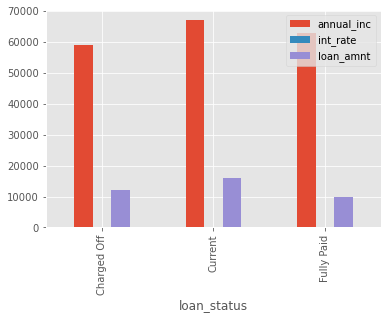

In [51]:
table.plot(kind='bar');

In [52]:
table = pd.pivot_table(data=non_null_df2 ,index=['grade','loan_status'], values=['annual_inc','loan_amnt','int_rate'],aggfunc={'annual_inc':np.median,'loan_amnt':np.median,'int_rate':np.median})

In [53]:
table

annual_inc  int_rate  loan_amnt
grade loan_status                                 
A     Charged Off   51,962.00      0.08   7,487.50
      Current       55,200.00      0.08  12,000.00
      Fully Paid    62,000.00      0.07   8,000.00
B     Charged Off   56,000.00      0.11  10,000.00
      Current       66,000.00      0.12  16,275.00
      Fully Paid    62,352.00      0.11  10,000.00
C     Charged Off   55,100.00      0.13  10,000.00
      Current       65,000.00      0.14  16,000.00
      Fully Paid    60,000.00      0.13  10,000.00
D     Charged Off   60,000.00      0.16  12,000.00
      Current       60,000.00      0.17  15,000.00
      Fully Paid    63,368.00      0.16  11,637.50
E     Charged Off   62,000.00      0.18  15,775.00
      Current       68,900.00      0.19  18,212.50
      Fully Paid    69,000.00      0.17  15,000.00
F     Charged Off   67,200.00      0.20  20,000.00
      Current       83,000.00      0.21  23,000.00
      Fully Paid    75,000.00      0.19  18,000.00
G     Charged Off   70,500.00      0.21  20,000.00
      Current       86,400.00      0.23  20,000.00
      Fully Paid    85,000.00      0.21  24,000.00

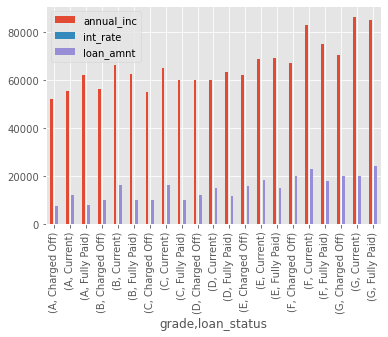

In [54]:
table.plot(kind='bar');

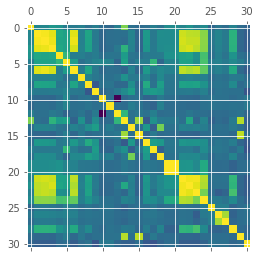

In [55]:
plt.matshow(non_null_df2.corr())
plt.show()